In [ ]:
import sys
print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read data
import pandas as pd
csv_file = pd.read_csv('/content/drive/MyDrive/train_models/data_used.csv')
#csv_file.head()

In [ ]:
csv_file[csv_file["valid"] == 1] # remove invalid images
invalid_images = csv_file[csv_file["valid"] == 1].index
csv_file = csv_file[csv_file["valid"] == 0]

In [ ]:
y = csv_file['scaled_rating']

In [ ]:
import numpy as np
from PIL import Image
import os

X = [] #images
for i in range(1500): # make sure images are read in the same order
  if i in invalid_images:
    continue
  # print(i)
  loaded_img = np.array(Image.open("images_backup/" + str(i) + ".jpg").resize((224, 224)))
  X.append(loaded_img / 255)

In [ ]:
# from matplotlib import pyplot as plt
# plt.imshow(X[2], interpolation='nearest')
# plt.show()

In [ ]:
X = np.asarray(X, dtype=np.float32)
X.shape,y.shape

((1491, 224, 224, 3), (1491,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
(X_test, X_val, y_test, y_val) = train_test_split(X_test, y_test, train_size=0.5, random_state=1)


In [ ]:
len(X_train),len(y_train),len(X_val),len(y_val),len(X_test),len(y_test)

(1043, 1043, 224, 224, 224, 224)

In [ ]:
X_train.shape,y_train.shape

((1043, 224, 224, 3), (1043,))

In [ ]:
sorted(pd.Series(y_test).index)

[37,
 49,
 51,
 56,
 65,
 73,
 80,
 81,
 87,
 88,
 90,
 98,
 101,
 104,
 107,
 115,
 132,
 134,
 141,
 155,
 160,
 164,
 170,
 178,
 182,
 187,
 191,
 195,
 196,
 199,
 202,
 203,
 205,
 212,
 216,
 217,
 243,
 260,
 264,
 269,
 272,
 282,
 285,
 300,
 303,
 304,
 311,
 317,
 333,
 337,
 353,
 362,
 375,
 385,
 389,
 398,
 402,
 403,
 407,
 411,
 412,
 430,
 436,
 439,
 456,
 464,
 468,
 484,
 491,
 499,
 516,
 524,
 525,
 532,
 535,
 538,
 539,
 557,
 560,
 581,
 585,
 588,
 591,
 593,
 596,
 602,
 606,
 620,
 626,
 632,
 640,
 644,
 648,
 651,
 653,
 654,
 658,
 663,
 665,
 668,
 675,
 687,
 698,
 705,
 711,
 728,
 734,
 739,
 741,
 758,
 759,
 765,
 769,
 770,
 776,
 781,
 786,
 790,
 793,
 795,
 803,
 814,
 816,
 819,
 825,
 838,
 849,
 850,
 855,
 856,
 863,
 867,
 878,
 880,
 885,
 889,
 898,
 902,
 913,
 917,
 920,
 923,
 929,
 934,
 945,
 955,
 957,
 965,
 983,
 984,
 986,
 994,
 1001,
 1007,
 1011,
 1013,
 1017,
 1027,
 1031,
 1032,
 1033,
 1036,
 1042,
 1045,
 1052,
 1059,
 1

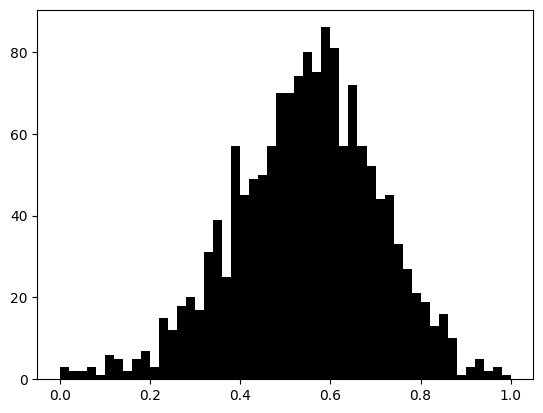

In [ ]:
from matplotlib import pyplot as plt
plt.hist(y, bins = 50,color = 'black')
# plt.title("Distribution of ")
plt.show()

In [ ]:
y.mean()

0.5482006818647557

In [ ]:
y.median()

0.5552753806382391

In [ ]:
# from keras.preprocessing import image
from keras.applications import VGG16#, resnet
from keras.applications.resnet import ResNet50
from keras.applications import Xception
from keras.layers import *
from keras.models import Model#,Sequential
from keras import optimizers
from keras import regularizers
from keras import losses
from keras import metrics

resnet_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

resnet_base.trainable = False
# resnet_base.summary()

flat = Flatten()(resnet_base.output)   #Flatten the output layer from Resnet model
dense = Dense(128,activation='relu')(flat)
drop = Dropout(0.5)(dense)
dense = Dense(64,activation='relu')(dense)
drop = Dropout(0.5)(dense)
last = Dense(1, activation='linear')(drop)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# resnet_base.summary()
# print(len(resnet_base.layers))

175


In [ ]:
res_model = Model(resnet_base.input, last) #(input, output)
res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
print(len(res_model.layers))

180


In [ ]:

res_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanSquaredError()])

res_model.fit(X_train, y_train,
          batch_size=32,
          epochs=30,
          validation_data=(X_val, y_val))

Epoch 1/30
33/33 [==============================] - 283s 8s/step - loss: 0.5462 - mean_squared_error: 0.5462 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 2/30
33/33 [==============================] - 313s 10s/step - loss: 0.1055 - mean_squared_error: 0.1055 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 3/30
33/33 [==============================] - 291s 9s/step - loss: 0.0639 - mean_squared_error: 0.0639 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 4/30
33/33 [==============================] - 259s 8s/step - loss: 0.0579 - mean_squared_error: 0.0579 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 5/30
33/33 [==============================] - 293s 9s/step - loss: 0.0532 - mean_squared_error: 0.0532 - val_loss: 0.0253 - val_mean_squared_error: 0.0253
Epoch 6/30
33/33 [==============================] - 300s 9s/step - loss: 0.0549 - mean_squared_error: 0.0549 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 7/30
33/33 [===============

In [ ]:
y_pred = res_model.predict(X_test)
print(np.min(y_pred.flatten()),np.max(y_pred.flatten()))
# epoch = 40 batch = 32 0.3397864 0.86198807 (0.03440237260006873, 0.14630122029164958)
                     #   0.40206674 0.77312315 0.030915997358259287, 0.13684650702700904
# epoch = 40 batch = 16 0.31501675 0.72410274 (0.03533305386633482, 0.15176279086707528)
# epoch = 30 batch = 16 0.43129438 0.7536362 0.032212322367605406, 0.13910845098657149
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
print(mean_squared_error(y_test.tolist(), y_pred),mean_absolute_error(y_test.tolist(), y_pred))
print(mean_squared_error(y_test.tolist(), y_pred,squared=False))

In [ ]:
r2_score(y_test.tolist(),y_pred)

In [ ]:
res_model.save('res_model.keras')

In [ ]:
# Xception
xception_base = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

xception_base.trainable = False

flat = Flatten()(xception_base.output)   #Flatten the output layer from Resnet model
dense = Dense(128,activation='relu')(flat)
drop = Dropout(0.5)(dense)
dense = Dense(64,activation='relu')(dense)
drop = Dropout(0.5)(dense)
last = Dense(1, activation='linear')(drop)

xception_model = Model(xception_base.input, last) #(input, output)
xception_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                    

In [ ]:
print(len(xception_model.layers))

137


In [ ]:
xception_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), #MeanAbsoluteError()
              loss=losses.MeanSquaredError(),#MeanSquaredError()
              metrics=[metrics.MeanSquaredError()]) #RootMeanSquaredError()
xception_model.fit(X_train, y_train,
          batch_size=32, #128
          epochs=30,
          validation_data=(X_val, y_val))

In [ ]:
y_pred = xception_model.predict(X_test)
print(np.min(y_pred.flatten()),np.max(y_pred.flatten()))
# epoch = 30 batch = 32 (0.33998176 0.7651924) MSE: 0.03646200621666953 MAE: 0.1522925781871214
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
print(mean_squared_error(y_test.tolist(), y_pred),mean_absolute_error(y_test.tolist(), y_pred))
print(mean_squared_error(y_test.tolist(), y_pred,squared=False))

In [ ]:
r2_score(y_test.tolist(),y_pred)

In [ ]:
xception_model.save('xception_model.keras')

In [ ]:
# VGG 16
vgg_base = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

vgg_base.trainable = False

flat = Flatten()(vgg_base.output)   #Flatten the output layer from Resnet model
dense = Dense(128,activation='relu')(flat)
drop = Dropout(0.5)(dense)
dense = Dense(64,activation='relu')(dense)
drop = Dropout(0.5)(dense)
last = Dense(1, activation='linear')(drop)

vgg_model = Model(vgg_base.input, last) #(input, output)
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
print(len(vgg_model.layers))

24


In [ ]:
vgg_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), #MeanAbsoluteError()
              loss=losses.MeanSquaredError(),#MeanSquaredError()
              metrics=[metrics.MeanSquaredError()])
vgg_model.fit(X_train, y_train,
          batch_size=32, #128
          epochs=30,
          validation_data=(X_val, y_val))


In [ ]:
# vgg_model = train(vgg_model)
y_pred = vgg_model.predict(X_test)
print(np.min(y_pred.flatten()),np.max(y_pred.flatten()))

from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
print(mean_squared_error(y_test.tolist(), y_pred),mean_absolute_error(y_test.tolist(), y_pred))
print(mean_squared_error(y_test.tolist(), y_pred,squared=False))

In [ ]:
r2_score(y_test.tolist(),y_pred)

In [ ]:
vgg_model.save('vgg_model.keras')

In [ ]:
from google.colab import files
files.download('/content/vgg_model.keras')
files.download('/content/res_model.keras')
files.download('/content/xception_model.keras')